In [3]:
import numpy as np
import glob
import xarray as xr
import sys, traceback
import pdb

import matplotlib.pyplot as plt
from matplotlib import rcParams

from scipy.special import gamma

# CPOL convenience functions
import CPOL_func as cf
import caine_func as caf

In [4]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
if __name__ == '__main__':
    try:
        caf.WRF_to_pyart(mp='thompson')
        
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting conversions.
Starting c

In [5]:
wrf = xr.open_dataset('/g/data/w40/esh563/thompson/d04.dir/wrfout_d04_2006-02-09_10:00:00.nc.gz')
# test = xr.open_dataset('/g/data/w40/esh563/d04.dir/wrfout_d04_2006-02-09_10:00:00.nc.gz')
# hgt_AGL = np.load('/g/data/w40/esh563/d04_hgt_AGL.npy')
# # Create function to de
# def moving_average(a, n=3):
#     ret = np.cumsum(a, dtype=float)
#     ret[n:] = ret[n:] - ret[:-n]
#     return ret[n - 1:] / n
wrf = wrf.isel(Time=2)
z = (wrf.PH + wrf.PHB)/9.80665
# wrf['bottom_top']=moving_average(hgt_AGL, n=2)
# wrf['bottom_top_stag'] = hgt_AGL

In [97]:
wrf = xr.open_dataset('/g/data/w40/esh563/thompson/d04.dir/wrfout_d04_2006-02-13_12:00:00.nc.gz')


In [98]:
wrf.Times.size

1

In [92]:
wrf

<xarray.DataArray 'Times' ()>
array(b'2006-02-09_10:20:00', dtype='|S19')

In [48]:
# wrf.drop(labels=None
wrf_water = wrf[['QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 
                 'QNICE', 'QNRAIN',
                 'T', 'P', 'PB']]
wrf_water['west_east'] = wrf_water.XLONG[0,:]
wrf_water['south_north'] = wrf_water.XLAT[:,0]
# wrf_water = wrf_water.drop(['XLONG', 'XLAT'])

U = wrf['U']
U = U.rolling(west_east_stag=2, center=True).mean().dropna('west_east_stag')
U['west_east_stag'] = wrf_water['west_east'].values
U = U.rename({'west_east_stag' : 'west_east'})
U['south_north'] = U.XLAT_U[:,0].values
U = U.drop(['XLONG_U', 'XLAT_U'])
U.name = 'U'

V = wrf['V']
V = V.rolling(south_north_stag=2, center=True).mean().dropna('south_north_stag')
V['south_north_stag'] = wrf_water['south_north'].values
V = V.rename({'south_north_stag' : 'south_north'})
V['west_east'] = V.XLONG_V[0,:].values
V = V.drop(['XLONG_V', 'XLAT_V'])
V.name = 'V'

wrf_vert = wrf[['W', 'PH', 'PHB']]
wrf_vert['west_east'] = wrf_vert.XLONG[0,:]
wrf_vert['south_north'] = wrf_vert.XLAT[:,0]
wrf_vert = wrf_vert.drop(['XLONG', 'XLAT'])
wrf_vert = wrf_vert.rolling(bottom_top_stag=2, center=True).mean().dropna('bottom_top_stag')
wrf_vert = wrf_vert.rename({'bottom_top_stag' : 'bottom_top'})

wrf_water = xr.merge([wrf_water, U, V, wrf_vert])

In [49]:
wrf_water = wrf_water.coarsen(west_east=2, boundary='trim', side='left').mean()
wrf_water = wrf_water.coarsen(south_north=2, boundary='trim', side='left').mean()

In [50]:
wrf_water = wrf_water.sel(west_east = slice(129.70584, 132.39513))
wrf_water = wrf_water.sel(south_north = slice(-13.55555, -10.931778))
# wrf_water = wrf_water.isel(west_east = slice(136, 252))
# wrf_water = wrf_water.isel(south_north = slice(34, 150))

In [51]:
longitude = wrf_water.XLONG.values
longitude = np.expand_dims(longitude, 0)
longitude = np.concatenate([longitude] * 41)
longitude = np.expand_dims(longitude, 0)

latitude = wrf_water.XLAT.values
latitude = np.expand_dims(latitude, 0)
latitude = np.concatenate([latitude] * 41)
latitude = np.expand_dims(latitude, 0)

In [52]:
from numba import jit
from numba import int32

In [53]:
@jit()
def test_fun(field, z):
    test_int = np.ones((41,117,117)) * np.nan
    z_int = np.arange(0.0,20500.0,500.0)
#     z = (wrf_water.PH+wrf_water.PHB)/9.80665

    for i in range(117):
        for j in range(117):
            test_int[:,i,j] = np.interp(z_int, z[:,i,j], field[:,i,j], left=np.nan)
    return test_int

In [54]:
var_list = ['QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 
            'QNICE', 'QNRAIN',
            'T', 'P', 'PB', 'U', 'V', 'W']
ds_list = []
x = np.arange(-145000.0, 145000.0 + 2500.0, 2500.0)
y = np.arange(-145000.0, 145000.0 + 2500.0, 2500.0)
for v in var_list:
    test_innt = test_fun(wrf_water[v].values, 
                         ((wrf_water.PH+wrf_water.PHB)/9.80665).values)
    # Expand dims
    # Add time dimension
    ds = xr.Dataset({v: (['z', 'y', 'x'],  test_innt),},
                    coords={'y': y,
                            'x': x,
                            'z': np.arange(0.0,20500.0,500.0)})
    ds_list.append(ds)

In [55]:
# # Add latitude longitude values
# longitude = wrf_water.XLONG.values
# longitude = np.expand_dims(longitude, 0)
# longitude = np.concatenate([longitude] * 41)
# # longitude = np.expand_dims(longitude, 0)
# ds = xr.Dataset({'longitude': (['z', 'y', 'x'],  longitude),},
#                 coords={'y': y, 'x': x, 'z': z})
# ds_list.append(ds)

# latitude = wrf_water.XLAT.values
# latitude = np.expand_dims(latitude, 0)
# latitude = np.concatenate([latitude] * 41)
# # latitude = np.expand_dims(latitude, 0)
# ds = xr.Dataset({'latitude': (['z', 'y', 'x'],  latitude),},
#                 coords={'y': y, 'x': x, 'z': z})
# ds_list.append(ds)

interpi = xr.merge(ds_list)

In [56]:
# rho_air = 1.225
N0r = 8*10**6
N0g = 4*10**6
N0s = 2*10**7
rho_rain = 1000
rho_snow = 100
rho_graup = 400
rho_ice = 890

In [57]:
T = (interpi.T + 300)*(100000/(interpi.PB+interpi.P)) ** (-0.286) - 273.15

In [88]:
interpi

<xarray.Dataset>
Dimensions:  (x: 117, y: 117, z: 41)
Coordinates:
  * y        (y) float64 -1.45e+05 -1.425e+05 -1.4e+05 ... 1.425e+05 1.45e+05
  * x        (x) float64 -1.45e+05 -1.425e+05 -1.4e+05 ... 1.425e+05 1.45e+05
  * z        (z) float64 0.0 500.0 1e+03 1.5e+03 ... 1.9e+04 1.95e+04 2e+04
Data variables:
    QVAPOR   (z, y, x) float64 nan nan nan nan ... 4.179e-06 4.18e-06 4.181e-06
    QCLOUD   (z, y, x) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    QRAIN    (z, y, x) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    QICE     (z, y, x) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    QSNOW    (z, y, x) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    QGRAUP   (z, y, x) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    QNICE    (z, y, x) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    QNRAIN   (z, y, x) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    T        (z, y, x) float64 nan nan nan nan nan .

In [89]:
rho_air=(interpi.P+interpi.PB)/(287*(T+273.15)*(0.622+interpi.QVAPOR)/(0.622*(1+interpi.QVAPOR)))

In [82]:
# Thompson Scheme

# Solve for rain reflectivity
lam_rain = (np.pi*rho_rain*interpi.QNRAIN*gamma(4)/(6*interpi.QRAIN*gamma(1)))**(1/3)
N0r = interpi.QNRAIN * lam_rain / gamma(1)
rain_ref = (6/np.pi)**2*(interpi.QRAIN**2/interpi.QNRAIN)*gamma(7)*rho_air/(rho_rain*gamma(4))**2

# Solve for graupel reflectivity
N1 = 10**4
N2 = 5*10**6
qg0 = 0.15*10**(-3)
N0g = ((N1-N2)/2)*np.tanh((qg0-interpi.QGRAUP)/qg0)+(N1+N2)/2
graup_ref = 720*(rho_air*interpi.QGRAUP)**(7/4)/(N0g**(3/4)*(np.pi*rho_graup)**(7/4))*(rho_graup/rho_ice)**2

# Solve for snow reflectivity
a = 5.065339-0.062659*T-3.032362*4+0.029469*T*4-0.000285*T**2+0.312550*4**2+0.00020*T**2*4+0.003199*T*4**2-0.015952*4**3
a = 10 ** a
b = 0.476221-0.015896*T+0.165977*4+0.007468*T*4-0.000141*T**2+0.060366*4**2+0.000079*T**2*4+0.000594*T*4**2-0.003577*4**3
snow_ref = 0.189*(0.069*6/(np.pi*rho_ice))**2*a*(interpi.QSNOW*rho_air/0.069)**b

# Z = 10 * np.log10(10 ** 18 * (rain_ref+snow_ref+graup_ref))
Z = 10 * np.log10(10 ** 18 * (snow_ref))
Z.values[Z<0] = np.nan
Z.name = 'reflectivity'

In [87]:
gamma(4)

6.0

<xarray.DataArray 'reflectivity' (z: 41)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       2.50690948, 4.73578329, 5.94876678, 6.36350193, 6.87091554,
       7.64820121, 8.23773196, 7.494721  , 6.16676395, 4.3841783 ,
       2.57988505, 0.82199614,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])
Coordinates:
    y        float64 -6e+04
    x        float64 5e+04
  * z        (z) float64 0.0 500.0 1e+03 1.5e+03 ... 1.9e+04 1.95e+04 2e+04

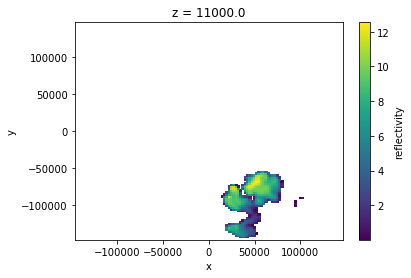

In [83]:
Z[22].plot()
Z.sel(x=50000).sel(y=-60000)

In [52]:
# Lin Scheme
rain_ref = 720 * (rho_air * interpi.QRAIN) ** (7/4) / (N0r ** (3/4) * (np.pi * rho_rain) ** (7/4))
snow_ref = 720 * (rho_air * interpi.QSNOW) ** (7/4) / (N0s ** (3/4) * (np.pi * rho_snow) ** (7/4)) * (rho_snow / rho_rain) ** 2 #* (T < 0) *  0.224 
graup_ref = 720 * (rho_air * interpi.QGRAUP) ** (7/4) / (N0g ** (3/4) * (np.pi * rho_graup) ** (7/4)) * (rho_graup / rho_rain) ** 2 #* (T < 0) * 0.224 

In [54]:
graup_ref.values[T.values<0] = graup_ref.values[T.values<0] * 0.224
snow_ref.values[T.values<0] = snow_ref.values[T.values<0] * 0.224

In [55]:
Z = 10 * np.log10(10 ** 18 * (rain_ref+snow_ref+graup_ref))

In [56]:
Z.values[Z<0] = np.nan
Z.name = 'reflectivity'

In [57]:
xr.merge([interpi,Z])

<xarray.Dataset>
Dimensions:       (x: 117, y: 117, z: 41)
Coordinates:
  * y             (y) float64 -1.45e+05 -1.425e+05 ... 1.425e+05 1.45e+05
  * x             (x) float64 -1.45e+05 -1.425e+05 ... 1.425e+05 1.45e+05
  * z             (z) float64 0.0 500.0 1e+03 1.5e+03 ... 1.9e+04 1.95e+04 2e+04
Data variables:
    QVAPOR        (z, y, x) float64 nan nan nan ... 3.942e-06 3.948e-06
    QCLOUD        (z, y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    QRAIN         (z, y, x) float64 nan nan nan ... 1.22e-36 2.273e-36 3.45e-36
    QICE          (z, y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    QSNOW         (z, y, x) float64 nan nan nan ... 2.75e-18 3.63e-18 2.908e-18
    QGRAUP        (z, y, x) float64 nan nan nan ... 8.566e-31 1.008e-30
    T             (z, y, x) float64 nan nan nan nan ... 153.5 153.4 153.3 153.3
    P             (z, y, x) float64 nan nan nan nan ... 19.88 19.99 20.14 20.39
    PB            (z, y, x) float64 nan nan nan ... 5.613e+

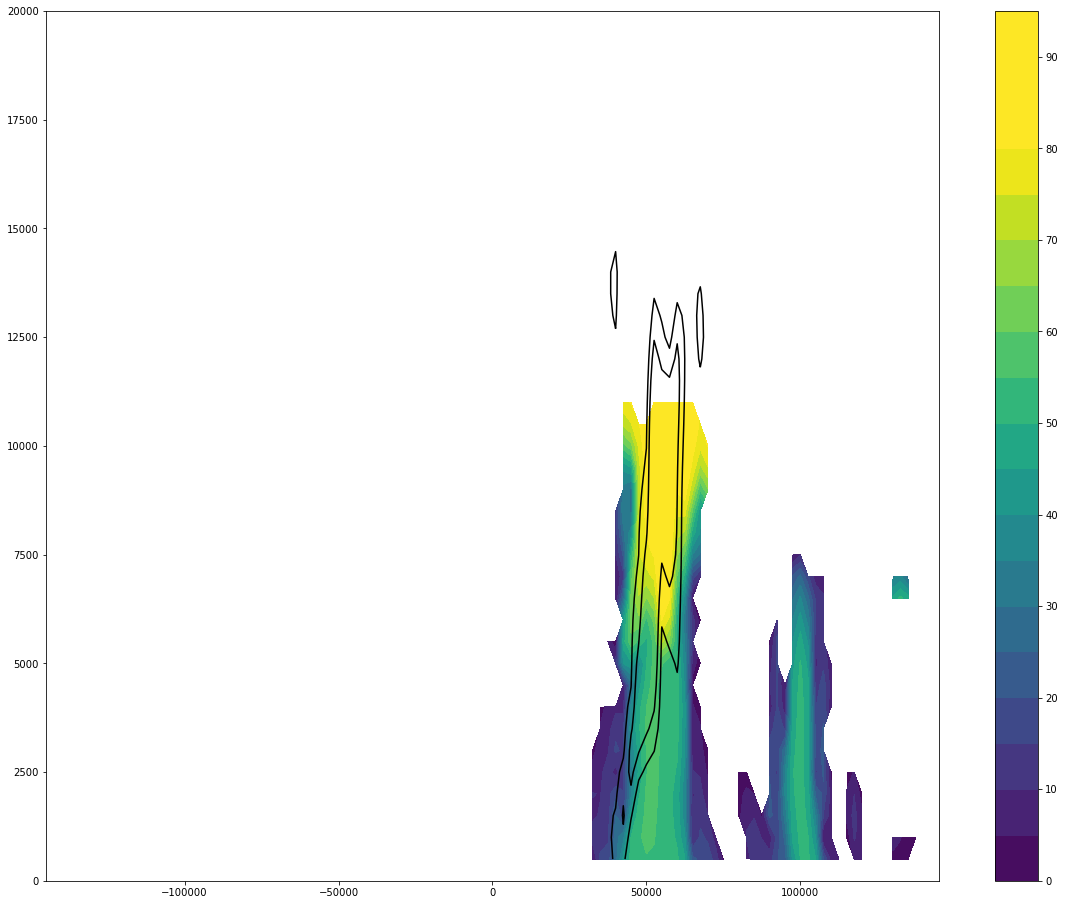

In [74]:
plt.figure(figsize=(20, 16))
W = interpi['W']
hgt_lev=5000
plt.contourf(Z.x, Z.z, Z.sel(y=-60000, method='nearest'), 20, vmin=0, vmax=80)
# plt.pcolormesh(Z.longitude, Z.latitude, Z.sel(z=hgt_lev, method='nearest'))
plt.colorbar()
plt.contour(W.x, W.z, W.sel(y=-60000, method='nearest'), colors='k', levels=[1,5])
# plt.contour(interpi.x, interpi.z, interpi['QRAIN'].sel(y=-60000, method='nearest'), colors='k', n=2)

In [366]:
W

<xarray.DataArray 'W' (bottom_top: 63, south_north: 117, west_east: 117)>
array([[[ 2.60939589e-03,  6.52425829e-03,  4.19883244e-03, ...,
         -6.53097685e-03,  3.43662570e-03,  2.74853483e-02],
        [-1.01577630e-03,  3.06889787e-03,  5.62066026e-03, ...,
         -1.40173659e-02, -1.09690893e-02,  8.36873055e-03],
        [-3.57101811e-03, -5.45208808e-03, -3.11506586e-03, ...,
         -1.63174532e-02, -1.52487298e-02, -4.71443404e-03],
        ...,
        [-6.64367992e-03, -9.68456827e-03, -1.02461800e-02, ...,
          2.43183598e-03,  2.61007017e-03,  2.43900297e-03],
        [ 1.66351534e-02,  2.11766548e-02,  2.03468390e-02, ...,
          2.96704425e-03,  3.84129328e-03,  5.17139724e-03],
        [ 1.36522111e-04,  2.30405713e-03,  4.51409817e-03, ...,
          2.58822134e-03,  4.38052556e-03,  6.22777687e-03]],

       [[ 7.09449966e-03,  1.87225118e-02,  1.26158912e-02, ...,
         -2.05852874e-02,  2.23021908e-03,  3.54014412e-02],
        [-3.20735690e-03,  8.